In [52]:
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.metrics import brier_score
from pysurvival.utils.display import integrated_brier_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Functions:
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

def calculateSurvivals(gender, age, t, grade, tumors, diam, cis, bcg) :
    recRate = 0
    cuetoR, cuetoP = calculateCUETO(gender, age, tumors, t, cis, grade)
    eortcR, eortcP = calculateEORTC(tumors, diam, recRate, t, cis, grade)

    varList = [gender, age, t, cis, grade, tumors, diam, bcg, eortcR, eortcP, cuetoR, cuetoP]

    ret = pd.DataFrame(columns = ['time [years]', 'PFS (95CI)', 'RFS (95CI)'])



    for i in range(1, 6) :

        #calculate PFS 
        pfs = pfsMod.predict_survival(varList, t = i)[0]
        #pfsL = pfsMod.predict_survival_lower(t = i)
        #pfsU = pfsMod.predict_survival_upper(t = i)

        #calcullate RFS
        rfs = rfsMod.predict_survival(varList, t = i)[0]
        #rfsL = rfsMod.predict_survival_lower(t = i)
        #rfsU = rfsMod.predict_survival_upper(t = i)


        tmp = pd.Series(
            [i, '{:.2f}%'.format(pfs * 100), '{:.2f}%'.format(rfs * 100)],
            index = ret.columns
        )

        ret = ret.append(tmp, ignore_index = True)

    return ret.to_dict('records')

In [96]:
Mod = NonLinearCoxPHModel()
Mod.load('modelData/final_rfs.zip')
dataset = pd.read_csv('Data/validation_rfs_old.csv')

Loading the model from modelData/final_rfs.zip


In [97]:
dataset.columns
dataset
varset = ['Gender', 'Age', 'T', 'CIS', 'Grading', 'No_tumors', 'Diameter', 'BCG', 'EORTC_R', 'EORTC_P', 'CUETO_R', 'CUETO_P']
data = dataframe_to_deepsurv_ds(dataset.loc[:, varset + ['Event','Time']], event_col = 'Event', time_col = 'Time')

In [98]:
concordance_index(Mod, data['x'], data['t'], data['e'], additional_results = True)

{0: 0.6507559374078781, 1: 91465.29999691226, 2: 59521.58703978342}

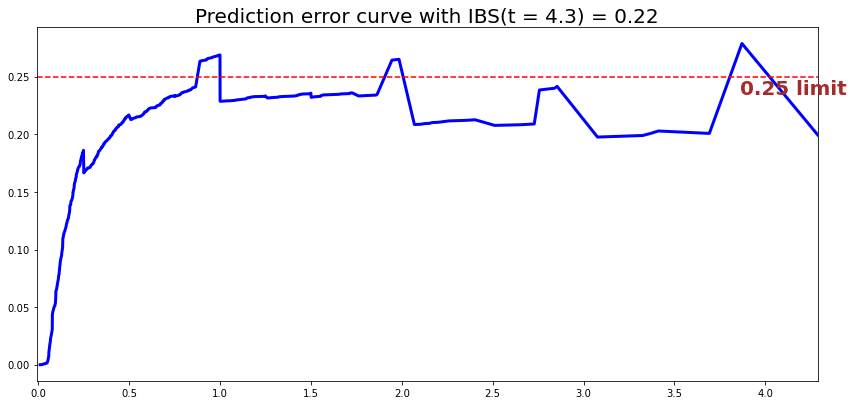

0.21535411147366781

In [99]:
bs = brier_score(Mod, data['x'], data['t'], data['e'], t_max=10)
ibs = integrated_brier_score(Mod, data['x'], data['t'], data['e'], t_max=10, figure_size=(14, 6.5) )
d = {'time': bs[0], 'bs': bs[1]}
df = pd.DataFrame(d)
ibs

In [78]:
ibs

array([0.99964301, 0.99928186, 0.99891696, 0.99855114, 0.99818116,
       0.99781062, 0.99743667, 0.99706228, 0.99668619, 0.9963087 ,
       0.9959302 , 0.9955515 , 0.99517158, 0.99479051, 0.99402818,
       0.99364612, 0.99287963, 0.99249466, 0.99210883, 0.99172206,
       0.9913342 , 0.9909445 , 0.99055387, 0.99016282, 0.98976993,
       0.9893766 , 0.98898194, 0.98858652, 0.98819078, 0.98779406,
       0.98739657, 0.986998  , 0.986598  , 0.98619717, 0.98579637,
       0.98539389, 0.98499126, 0.98418211, 0.98336767, 0.98295767,
       0.98254409, 0.98212805, 0.9817113 , 0.98129336, 0.98045451,
       0.98003332, 0.97960988, 0.97918555, 0.97876083, 0.9783355 ,
       0.97748509, 0.97705822, 0.97662732, 0.97619474, 0.97575798,
       0.97487776, 0.974427  , 0.97397478, 0.9735213 , 0.97306541,
       0.97260582, 0.97214593, 0.97168579, 0.97122327, 0.97075642,
       0.97028889, 0.96981592, 0.96934201, 0.96838855, 0.96791025,
       0.96743097, 0.96694887, 0.96646318, 0.96597496, 0.96548

In [49]:
df.to_csv("valResults/train_pfs_bs.csv")

/home/konrad/anaconda3/lib/python3.8/site-packages/pysurvival/utils/display.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1f}%'.format(v*100) for v in vals])


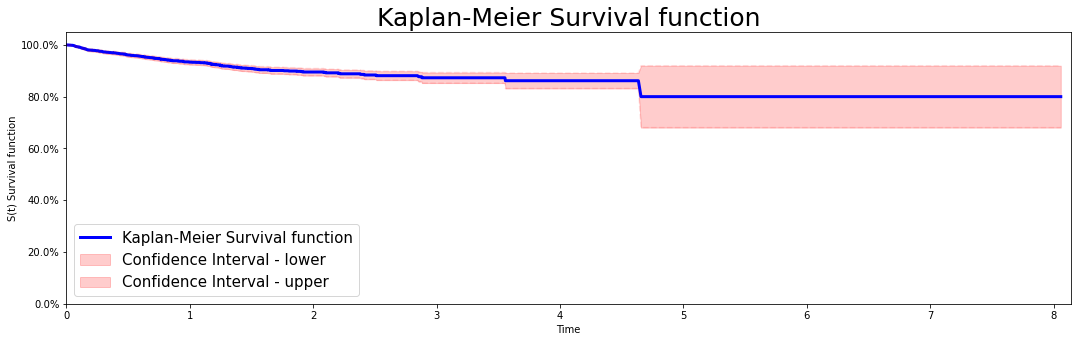

1324


In [58]:
#### 6 - Comparing actual and predictions
# Initializing the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((data['e']==1.)&(data['t']>=0)).flatten()
k = np.random.choice( choices, 1)[0]

# Saving the time of event
t = data['t'][k]

# Reference
from pysurvival.models.non_parametric import KaplanMeierModel
from pysurvival.utils.display import display_non_parametric
%matplotlib inline

# Initializing the KaplanMeierModel
km_model = KaplanMeierModel()

# Fitting the model 
km_model.fit(data['t'], data['e'], alpha=0.95)

# Displaying the survival function and confidence intervals
display_non_parametric(km_model)

km_model.times
print(k)